<a href="https://colab.research.google.com/github/jordantab/11785-assignment-part2s/blob/main/HW2P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW2P2: Image Recognition and Verification

This is the second homework  in 11785: Introduction to Deep Learning. We are trying to tackle the problem of Image Verification. For this, we will need to first train our own CNN model to tackle the problem of classification, consisting of 8631 identities. Using this, we get the face embeddings for different pairs of images and try to identify if the pair of face matches or not.

# Libraries

In [ ]:
!nvidia-smi # Run this to see what GPU you have

Thu Oct 10 16:57:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              42W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install wandb --quiet # Install WandB
!pip install pytorch_metric_learning --quiet #Install the Pytorch Metric Library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.8/313.8 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 10.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
from pytorch_metric_learning import losses
import csv

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


In [ ]:
from google.colab import drive # Link to your drive if you are not using Colab with GCP
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

Mounted at /content/drive


# Kaggle

In [ ]:
# TODO: Use the same Kaggle code from HW1P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"jordantab","key":"6012317c8cbe2756d1bf461f146b1d6e"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73248 sha256=8722723e5f5ffb191f342e5298dad18df6a915af7dfb82794b9f73b1f3a96e3e
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [ ]:
# # Reminder: Make sure you have connected your kaggle API before running this block
!mkdir '/content/data'

!kaggle competitions download -c 11785-hw-2-p-2-face-verification-fall-2024
!unzip -qo '11785-hw-2-p-2-face-verification-fall-2024.zip' -d '/content/data'

100% 2.75G/2.75G [02:25<00:00, 24.1MB/s]
100% 2.75G/2.75G [02:25<00:00, 20.3MB/s]


# Config

In [ ]:
run_name = "resnet34-6-finetune-1"

checkpoint_dir = f"/content/drive/My Drive/hw2p2/checkpoints/{run_name}"
os.makedirs(checkpoint_dir, exist_ok=True)

config = {
    'batch_size': 1024, # Increase this if your GPU can handle it
    'p': 0.5,
    'degrees': 10,
    'brightness': 0.2,
    'contrast': 0.2,
    'saturation': 0.2,
    'hue': 0.1,
    'lr':  1e-4,
    'margin_size': 28.6,
    'scale': 64,
    'weight_decay': 0.1,
    'momentum': 0.9,
    'epochs': 30, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    'data_dir': "data/11-785-f24-hw2p2-verification/cls_data", #TODO
    'data_ver_dir': "data/11-785-f24-hw2p2-verification/ver_data", #TODO
    'checkpoint_dir': checkpoint_dir, #TODO
    'run_name': run_name
    # Include other parameters as needed.
}

In [ ]:
print(os.path.exists('data/11-785-f24-hw2p2-verification'))

True


# Dataset

## Dataset Class for doing Image Verification

In [ ]:
class ImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2, match = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2), int(match)

In [ ]:
class TestImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2 = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2)

## Create Dataloaders for Image Recognition

In [ ]:
data_dir = config['data_dir']
# train_dir = os.path.join(data_dir)

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'dev')

# train transforms
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(112), # Why are we resizing the Image?
    torchvision.transforms.RandomHorizontalFlip(p=config['p']),
    torchvision.transforms.RandomRotation(degrees=config['degrees']),
    torchvision.transforms.ColorJitter(brightness=config['brightness'], contrast=config['contrast'], saturation=config['saturation'], hue=config['hue']),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                      std=[0.5, 0.5, 0.5])])

# val transforms
val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(112),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                      std=[0.5, 0.5, 0.5])])


# get datasets
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=config["batch_size"],
                                            shuffle=True,
                                            pin_memory=True,
                                            num_workers=8,
                                            sampler=None)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=config["batch_size"],
                                          shuffle=False,
                                          num_workers=4)

In [ ]:
data_dir = config['data_ver_dir']

# get datasets

# TODO: Add your validation pair txt file
pair_dataset = ImagePairDataset(data_dir, csv_file='data/11-785-f24-hw2p2-verification/val_pairs.txt', transform=val_transforms)
pair_dataloader = torch.utils.data.DataLoader(pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

# TODO: Add your validation pair txt file
test_pair_dataset = TestImagePairDataset(data_dir, csv_file='data/11-785-f24-hw2p2-verification/test_pairs.txt', transform=val_transforms)
test_pair_dataloader = torch.utils.data.DataLoader(test_pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

# EDA and Viz

In [ ]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", val_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  8631
No. of train images  :  431550
Shape of image       :  torch.Size([3, 112, 112])
Batch size           :  1024
Train batches        :  422
Val batches          :  43


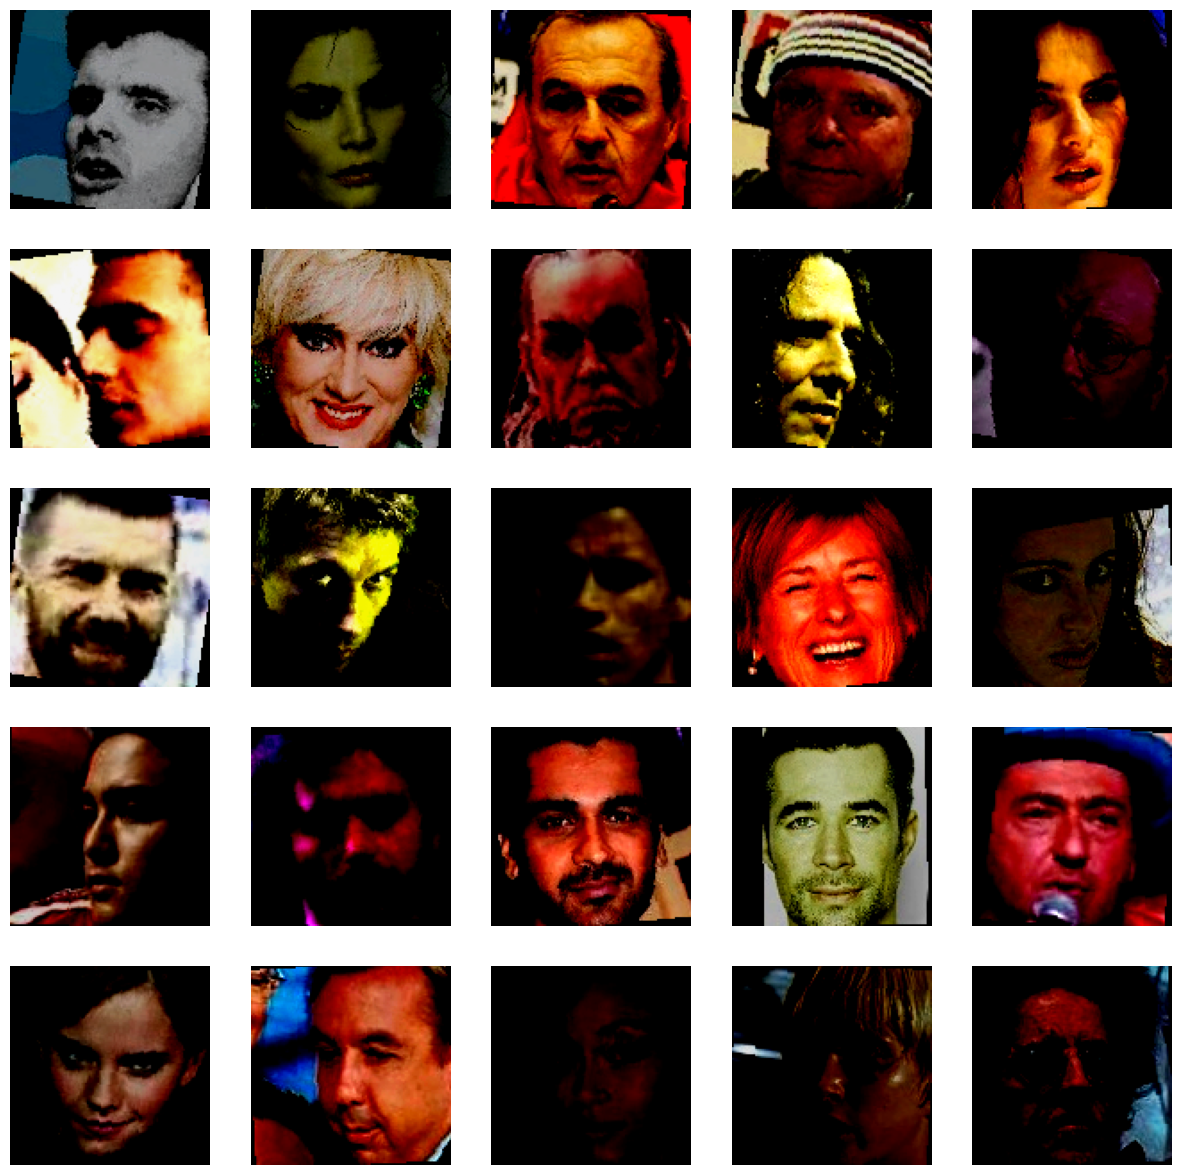

In [ ]:
# Visualize a few images in the dataset

"""
You can write your own code, and you don't need to understand the code
It is highly recommended that you visualize your data augmentation as sanity check
"""

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(train_dir, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit is 18M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 112x112. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [ ]:
# Residual Block for ResNet

class ResidualBlock(torch.nn.Module):
  expansion = 1

  def __init__(self, in_channels, out_channels, stride=1, downsample=None):
    super(ResidualBlock, self).__init__()
    self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1), torch.nn.BatchNorm2d(out_channels), torch.nn.ReLU())
    self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1), torch.nn.BatchNorm2d(out_channels))
    self.downsample = downsample
    self.relu = torch.nn.ReLU()

  def forward(self, x):
    residual = x

    # First convolutional layer
    out = self.conv1(x)

    # Second convolutional layer
    out = self.conv2(out)

    if self.downsample is not None:
      residual = self.downsample(x)

    out += residual
    out = self.relu(out)

    return out

In [ ]:
# ResNet Architecture stacking together blocks
class ResNet(torch.nn.Module):
  def __init__(self, block, layers, num_classes=8631):
    super(ResNet, self).__init__()
    self.in_channels = 64

    # Initial convolution and pooling layers
    self.conv1 = torch.nn.Sequential(
      torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
      torch.nn.BatchNorm2d(64),
      torch.nn.ReLU())
    self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # Residual blocks
    self.layer1 = self._make_layer(block, 64, layers[0])
    self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
    self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
    self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

    # Average pooling and fully connected layer
    self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
    self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

  def _make_layer(self, block, out_channels, blocks, stride=1):
    downsample = None
    if stride != 1 or self.in_channels != out_channels:
      downsample = torch.nn.Sequential(
          torch.nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=
                          1, stride=stride),
          torch.nn.BatchNorm2d(out_channels * block.expansion)
      )

    layers = []
    layers.append(block(self.in_channels, out_channels, stride, downsample))
    self.in_channels = out_channels * block.expansion
    for _ in range(1, blocks):
      layers.append(block(self.in_channels, out_channels))

    return torch.nn.Sequential(*layers)

  def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        feats = x
        out = self.fc(x)

        return {"feats": feats, "out": out}

model = ResNet(ResidualBlock, [3,4,6,3]).to(DEVICE)
summary(model, (3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           9,472
       BatchNorm2d-2           [-1, 64, 56, 56]             128
              ReLU-3           [-1, 64, 56, 56]               0
         MaxPool2d-4           [-1, 64, 28, 28]               0
            Conv2d-5           [-1, 64, 28, 28]          36,928
       BatchNorm2d-6           [-1, 64, 28, 28]             128
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          36,928
       BatchNorm2d-9           [-1, 64, 28, 28]             128
             ReLU-10           [-1, 64, 28, 28]               0
    ResidualBlock-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          36,928
      BatchNorm2d-13           [-1, 64, 28, 28]             128
             ReLU-14           [-1, 64,

In [ ]:
# Building block for ConvNeXt

class ConvNeXtBlock(nn.Module):
  def __init__(self, dim):
    super(ConvNeXtBlock, self).__init__()

    # Depthwise convolution
    self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)

    # Pointwise convolutions
    self.pwconv1 = nn.Linear(dim, 4 * dim)
    self.pwconv2 = nn.Linear(4 * dim, dim)

    # Normalization and activation
    self.ln = nn.LayerNorm(dim, eps=1e-6)
    self.gelu = nn.GELU()

  def forward(self, x):
    input = x

    x = self.dwconv(x)
    x = x.permute(0, 2, 3, 1)
    x = self.ln(x)
    x = self.pwconv1(x)
    x = self.gelu(x)
    x = self.pwconv2(x)
    x = x.permute(0, 3, 1, 2)
    x = x + input

    return x

In [ ]:
# Permute class

class Permute(nn.Module):
    def __init__(self, *dims):
        super(Permute, self).__init__()
        self.dims = dims

    def forward(self, x):
        return x.permute(*self.dims)

In [ ]:
# ConvNeXt-T architecture based on 'A ConvNet for the 2020s' (https://arxiv.org/abs/2201.03545)

class ConvNeXt(nn.Module):
  def __init__(self, in_channels=3, num_classes=8631, depths=[3, 3, 9, 3], dims=[96, 192, 384, 768]):
    super(ConvNeXt, self).__init__()

    # Downsampling layers initilization
    self.downsampling_layers = nn.ModuleList()

    # Stem layer
    stem = nn.Sequential(
        nn.Conv2d(in_channels, dims[0], kernel_size=4, stride=4),
        Permute(0, 2, 3, 1),
        nn.LayerNorm(dims[0], eps=1e-6),
        Permute(0, 3, 1, 2),
    )
    self.downsampling_layers.append(stem)

    # Downsampling layers
    for i in range(3):
      downsampling_layer = nn.Sequential(
          Permute(0, 2, 3, 1),
          nn.LayerNorm(dims[i], eps=1e-6),
          Permute(0, 3, 1, 2),
          nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2)
      )
      self.downsampling_layers.append(downsampling_layer)

    # Stages
    self.stages = nn.ModuleList()
    for i in range(4):
      stage = nn.Sequential(
          *[ConvNeXtBlock(dims[i]) for _ in range(depths[i])]
      )
      self.stages.append(stage)

    # Final normalization and classification head
    self.norm = nn.LayerNorm(dims[-1], eps=1e-6)
    self.head = nn.Linear(dims[-1], num_classes)

  def forward(self, x):
    for i in range(4):
      # Downsample between stages
      x = self.downsampling_layers[i](x)
      x = self.stages[i](x)
    x = x.mean([-2, -1])
    feats = x
    x = self.norm(x)
    out = self.head(x)

    return {"feats": feats, "out": out}

# model = ConvNeXt().to(DEVICE)
# summary(model, input_size=(3, 122, 122))

In [ ]:
# --------------------------------------------------- #

# Defining Loss function
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
# criterion = losses.ArcFaceLoss(num_classes=8631, embedding_size=512, margin=config['margin_size'], scale=config['scale'])

# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr= config['lr'], momentum=config['momentum'], weight_decay=config['weight_decay'])
# --------------------------------------------------- #

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=config['T_0'])
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=config['T_0'], T_mult=['T_mult'])

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

<ipython-input-46-56f8adea5b62>:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


# Metrics

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [ ]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

# Train and Validation Function

In [ ]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):

    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        # send to cuda
        images = images.to(device, non_blocking=True)
        if isinstance(labels, (tuple, list)):
            targets1, targets2, lam = labels
            labels = (targets1.to(device), targets2.to(device), lam)
        else:
            labels = labels.to(device, non_blocking=True)

        # forward
        with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
            outputs = model(images)

            # Use the type of output depending on the loss function you want to use
            loss = criterion(outputs['feats'], labels)

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()
        # metrics
        loss_m.update(loss.item())
        if 'feats' in outputs:
            acc = accuracy(outputs['out'], labels)[0].item()
        else:
            acc = 0.0
        acc_m.update(acc)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            # acc         = "{:.04f}%".format(100*accuracy),
            acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

    # You may want to call some schedulers inside the train function. What are these?
    if lr_scheduler is not None:
        lr_scheduler.step()

    batch_bar.close()

    return acc_m.avg, loss_m.avg

In [ ]:
@torch.no_grad()
def valid_epoch_cls(model, dataloader, device, config):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs['feats'], labels)

        # metrics
        acc = accuracy(outputs['out'], labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            acc         = "{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg))

        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Verification Task

In [ ]:
def valid_epoch_ver(model, pair_data_loader, device, config):

    model.eval()
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):

        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    return metric_dict['ACC'], metric_dict['EER']

# WandB

In [ ]:
wandb.login(key="4c68592a14802648ff3220711294d6e5fe7d272f") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
gen_id = wandb.util.generate_id()
print(gen_id)

9bils4j7


In [ ]:
# Create your wandb run
run = wandb.init(
    name = config['run_name'], ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # id = gen_id, ### Insert specific run id here if you want to resume a previous run
    # resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config, ### Wandb Config for your run
)

# Checkpointing and Loading Model

In [ ]:
# Uncomment the line for saving the scheduler save dict if you are using a scheduler
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'metric'                   : metrics,
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

In [ ]:
print(os.path.exists("best_cls.pth"))

False


In [ ]:
# from pytorch_metric_learning import losses
model, optimizer, scheduler, epoch, metrics = load_model(model, optimizer, scheduler, "best_ret (1).pth")

# optimizer = torch.optim.SGD(model.parameters(), lr=0.09989011473116477)

<ipython-input-56-917ec4f96c61>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


In [ ]:
criterion = losses.ArcFaceLoss(num_classes=8631, embedding_size=512, margin=config['margin_size'], scale=config['scale'])
optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'], momentum=config['momentum'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config['lr'], epochs=config['epochs'], steps_per_epoch=len(train_loader))

# Experiments

In [ ]:
e = 0
best_valid_cls_acc = 0.0
eval_cls = True
best_valid_ret_acc = 0.0
for epoch in range(e, config['epochs']):
        # epoch
        print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

        # train
        train_cls_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler, scaler, DEVICE, config)
        curr_lr = float(optimizer.param_groups[0]['lr'])
        print("\nEpoch {}/{}: \nTrain Cls. Acc {:.04f}%\t Train Cls. Loss {:.04f}\t Learning Rate {:.04f}".format(epoch + 1, config['epochs'], train_cls_acc, train_loss, curr_lr))
        metrics = {
            'train_cls_acc': train_cls_acc,
            'train_loss': train_loss,
        }
        # classification validation
        if eval_cls:
            valid_cls_acc, valid_loss = valid_epoch_cls(model, val_loader, DEVICE, config)
            print("Val Cls. Acc {:.04f}%\t Val Cls. Loss {:.04f}".format(valid_cls_acc, valid_loss))
            metrics.update({
                'valid_cls_acc': valid_cls_acc,
                'valid_loss': valid_loss,
            })
            scheduler.step(valid_loss)

        # retrieval validation
        valid_ret_acc, valid_eer = valid_epoch_ver(model, pair_dataloader, DEVICE, config)
        print("Val Ret. Acc {:.04f}%".format(valid_ret_acc))
        metrics.update({
            'valid_ret_acc': valid_ret_acc,
            'valid_eer': valid_eer,
            'lr': curr_lr
        })

        # save model
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'last.pth'))
        print("Saved epoch model")

        # save best model
        if eval_cls:
            if valid_cls_acc >= best_valid_cls_acc:
                best_valid_cls_acc = valid_cls_acc
                save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                wandb.save(os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                print("Saved best classification model")

        if valid_ret_acc >= best_valid_ret_acc:
            best_valid_ret_acc = valid_ret_acc
            save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            wandb.save(os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            print("Saved best retrieval model")

        # log to tracker
        if run is not None:
            run.log(metrics)


Epoch 1/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 1/30: 
Train Cls. Acc 98.7572%	 Train Cls. Loss 43.5728	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 84.0000%	 Val Cls. Loss 43.5449


{'ACC': 79.1, 'EER': 21.181262729124605, 'AUC': 85.99986395592171, 'TPRs': [('TPR@FPR=1e-4', 9.572301425661914), ('TPR@FPR=5e-4', 9.572301425661914), ('TPR@FPR=1e-3', 9.572301425661914), ('TPR@FPR=5e-3', 23.014256619144604), ('TPR@FPR=5e-2', 50.509164969450104)]}
Val Ret. Acc 79.1000%
Saved epoch model


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Saved best classification model
Saved best retrieval model

Epoch 2/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 2/30: 
Train Cls. Acc 98.7465%	 Train Cls. Loss 43.5587	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.9796%	 Val Cls. Loss 43.5305


{'ACC': 78.9, 'EER': 21.181262729171948, 'AUC': 85.9778568256115, 'TPRs': [('TPR@FPR=1e-4', 9.368635437881874), ('TPR@FPR=5e-4', 9.368635437881874), ('TPR@FPR=1e-3', 9.368635437881874), ('TPR@FPR=5e-3', 23.014256619144604), ('TPR@FPR=5e-2', 50.509164969450104)]}
Val Ret. Acc 78.9000%
Saved epoch model

Epoch 3/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 3/30: 
Train Cls. Acc 98.7712%	 Train Cls. Loss 43.5435	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.9682%	 Val Cls. Loss 43.5170


{'ACC': 79.0, 'EER': 21.38492871690344, 'AUC': 85.98665967773557, 'TPRs': [('TPR@FPR=1e-4', 9.572301425661914), ('TPR@FPR=5e-4', 9.572301425661914), ('TPR@FPR=1e-3', 9.572301425661914), ('TPR@FPR=5e-3', 23.014256619144604), ('TPR@FPR=5e-2', 50.71283095723014)]}
Val Ret. Acc 79.0000%
Saved epoch model

Epoch 4/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 4/30: 
Train Cls. Acc 98.7776%	 Train Cls. Loss 43.5283	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.9795%	 Val Cls. Loss 43.5031


{'ACC': 78.9, 'EER': 21.18126272912425, 'AUC': 85.95224852852324, 'TPRs': [('TPR@FPR=1e-4', 8.961303462321792), ('TPR@FPR=5e-4', 8.961303462321792), ('TPR@FPR=1e-3', 8.961303462321792), ('TPR@FPR=5e-3', 23.217922606924642), ('TPR@FPR=5e-2', 50.509164969450104)]}
Val Ret. Acc 78.9000%
Saved epoch model

Epoch 5/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 5/30: 
Train Cls. Acc 98.7545%	 Train Cls. Loss 43.5125	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.9613%	 Val Cls. Loss 43.4878


{'ACC': 78.9, 'EER': 21.588594704679238, 'AUC': 85.8982310268527, 'TPRs': [('TPR@FPR=1e-4', 9.775967413441954), ('TPR@FPR=5e-4', 9.775967413441954), ('TPR@FPR=1e-3', 9.775967413441954), ('TPR@FPR=5e-3', 23.217922606924642), ('TPR@FPR=5e-2', 50.91649694501018)]}
Val Ret. Acc 78.9000%
Saved epoch model

Epoch 6/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 6/30: 
Train Cls. Acc 98.7785%	 Train Cls. Loss 43.4990	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.9999%	 Val Cls. Loss 43.4736


{'ACC': 78.9, 'EER': 21.38492871689906, 'AUC': 85.94544632460918, 'TPRs': [('TPR@FPR=1e-4', 9.368635437881874), ('TPR@FPR=5e-4', 9.368635437881874), ('TPR@FPR=1e-3', 9.368635437881874), ('TPR@FPR=5e-3', 23.217922606924642), ('TPR@FPR=5e-2', 50.91649694501018)]}
Val Ret. Acc 78.9000%
Saved epoch model

Epoch 7/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 7/30: 
Train Cls. Acc 98.7517%	 Train Cls. Loss 43.4825	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.9750%	 Val Cls. Loss 43.4604


{'ACC': 79.1, 'EER': 21.384928716913283, 'AUC': 85.96345215849934, 'TPRs': [('TPR@FPR=1e-4', 9.164969450101832), ('TPR@FPR=5e-4', 9.164969450101832), ('TPR@FPR=1e-3', 9.164969450101832), ('TPR@FPR=5e-3', 23.421588594704684), ('TPR@FPR=5e-2', 50.91649694501018)]}
Val Ret. Acc 79.1000%
Saved epoch model
Saved best retrieval model

Epoch 8/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 8/30: 
Train Cls. Acc 98.7260%	 Train Cls. Loss 43.4692	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.9477%	 Val Cls. Loss 43.4450


{'ACC': 78.8, 'EER': 21.384928716904273, 'AUC': 85.90423297148277, 'TPRs': [('TPR@FPR=1e-4', 9.164969450101832), ('TPR@FPR=5e-4', 9.164969450101832), ('TPR@FPR=1e-3', 9.164969450101832), ('TPR@FPR=5e-3', 23.217922606924642), ('TPR@FPR=5e-2', 50.91649694501018)]}
Val Ret. Acc 78.8000%
Saved epoch model

Epoch 9/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 9/30: 
Train Cls. Acc 98.7076%	 Train Cls. Loss 43.4550	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.9318%	 Val Cls. Loss 43.4314


{'ACC': 78.9, 'EER': 21.384928716904287, 'AUC': 85.91183543468084, 'TPRs': [('TPR@FPR=1e-4', 9.164969450101832), ('TPR@FPR=5e-4', 9.164969450101832), ('TPR@FPR=1e-3', 9.164969450101832), ('TPR@FPR=5e-3', 23.421588594704684), ('TPR@FPR=5e-2', 50.71283095723014)]}
Val Ret. Acc 78.9000%
Saved epoch model

Epoch 10/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 10/30: 
Train Cls. Acc 98.7098%	 Train Cls. Loss 43.4416	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.9318%	 Val Cls. Loss 43.4164


{'ACC': 78.7, 'EER': 21.588594704684315, 'AUC': 85.95905073243732, 'TPRs': [('TPR@FPR=1e-4', 10.183299389002038), ('TPR@FPR=5e-4', 10.183299389002038), ('TPR@FPR=1e-3', 10.183299389002038), ('TPR@FPR=5e-3', 23.421588594704684), ('TPR@FPR=5e-2', 51.12016293279022)]}
Val Ret. Acc 78.7000%
Saved epoch model

Epoch 11/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 11/30: 
Train Cls. Acc 98.6926%	 Train Cls. Loss 43.4259	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.9544%	 Val Cls. Loss 43.4024


{'ACC': 78.7, 'EER': 21.58859470468372, 'AUC': 85.91183543468082, 'TPRs': [('TPR@FPR=1e-4', 10.183299389002038), ('TPR@FPR=5e-4', 10.183299389002038), ('TPR@FPR=1e-3', 10.183299389002038), ('TPR@FPR=5e-3', 23.421588594704684), ('TPR@FPR=5e-2', 50.71283095723014)]}
Val Ret. Acc 78.7000%
Saved epoch model

Epoch 12/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 12/30: 
Train Cls. Acc 98.6925%	 Train Cls. Loss 43.4097	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.9181%	 Val Cls. Loss 43.3875


{'ACC': 78.8, 'EER': 21.218074656194467, 'AUC': 85.88382635974055, 'TPRs': [('TPR@FPR=1e-4', 8.55397148676171), ('TPR@FPR=5e-4', 8.55397148676171), ('TPR@FPR=1e-3', 8.55397148676171), ('TPR@FPR=5e-3', 23.421588594704684), ('TPR@FPR=5e-2', 51.5274949083503)]}
Val Ret. Acc 78.8000%
Saved epoch model

Epoch 13/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 13/30: 
Train Cls. Acc 98.6997%	 Train Cls. Loss 43.3977	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.8795%	 Val Cls. Loss 43.3741


{'ACC': 78.6, 'EER': 21.61100196465768, 'AUC': 85.91623686074288, 'TPRs': [('TPR@FPR=1e-4', 9.368635437881874), ('TPR@FPR=5e-4', 9.368635437881874), ('TPR@FPR=1e-3', 9.368635437881874), ('TPR@FPR=5e-3', 23.217922606924642), ('TPR@FPR=5e-2', 51.5274949083503)]}
Val Ret. Acc 78.6000%
Saved epoch model

Epoch 14/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 14/30: 
Train Cls. Acc 98.6355%	 Train Cls. Loss 43.3826	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.8545%	 Val Cls. Loss 43.3600


{'ACC': 78.7, 'EER': 21.414538310505563, 'AUC': 85.89262921186463, 'TPRs': [('TPR@FPR=1e-4', 8.757637474541752), ('TPR@FPR=5e-4', 8.757637474541752), ('TPR@FPR=1e-3', 8.757637474541752), ('TPR@FPR=5e-3', 23.421588594704684), ('TPR@FPR=5e-2', 51.5274949083503)]}
Val Ret. Acc 78.7000%
Saved epoch model

Epoch 15/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 15/30: 
Train Cls. Acc 98.6544%	 Train Cls. Loss 43.3639	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.8363%	 Val Cls. Loss 43.3464


{'ACC': 78.7, 'EER': 21.792260692460548, 'AUC': 85.88222584117253, 'TPRs': [('TPR@FPR=1e-4', 9.572301425661914), ('TPR@FPR=5e-4', 9.572301425661914), ('TPR@FPR=1e-3', 9.572301425661914), ('TPR@FPR=5e-3', 23.217922606924642), ('TPR@FPR=5e-2', 51.12016293279022)]}
Val Ret. Acc 78.7000%
Saved epoch model

Epoch 16/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 16/30: 
Train Cls. Acc 98.6603%	 Train Cls. Loss 43.3521	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.8114%	 Val Cls. Loss 43.3305


{'ACC': 78.8, 'EER': 21.792260692462822, 'AUC': 85.87142234083844, 'TPRs': [('TPR@FPR=1e-4', 9.164969450101832), ('TPR@FPR=5e-4', 9.164969450101832), ('TPR@FPR=1e-3', 9.164969450101832), ('TPR@FPR=5e-3', 23.217922606924642), ('TPR@FPR=5e-2', 50.91649694501018)]}
Val Ret. Acc 78.8000%
Saved epoch model

Epoch 17/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 17/30: 
Train Cls. Acc 98.6302%	 Train Cls. Loss 43.3362	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.7410%	 Val Cls. Loss 43.3160


{'ACC': 78.8, 'EER': 21.79226069246106, 'AUC': 85.81260328346384, 'TPRs': [('TPR@FPR=1e-4', 8.757637474541752), ('TPR@FPR=5e-4', 8.757637474541752), ('TPR@FPR=1e-3', 8.757637474541752), ('TPR@FPR=5e-3', 23.828920570264767), ('TPR@FPR=5e-2', 51.73116089613035)]}
Val Ret. Acc 78.8000%
Saved epoch model

Epoch 18/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 18/30: 
Train Cls. Acc 98.5987%	 Train Cls. Loss 43.3217	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.7046%	 Val Cls. Loss 43.3017


{'ACC': 78.8, 'EER': 21.61100196466038, 'AUC': 85.87342298904845, 'TPRs': [('TPR@FPR=1e-4', 9.164969450101832), ('TPR@FPR=5e-4', 9.164969450101832), ('TPR@FPR=1e-3', 9.164969450101832), ('TPR@FPR=5e-3', 23.625254582484725), ('TPR@FPR=5e-2', 51.12016293279022)]}
Val Ret. Acc 78.8000%
Saved epoch model

Epoch 19/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 19/30: 
Train Cls. Acc 98.5892%	 Train Cls. Loss 43.3061	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.6774%	 Val Cls. Loss 43.2876


{'ACC': 78.7, 'EER': 21.79226069248519, 'AUC': 85.85341650694825, 'TPRs': [('TPR@FPR=1e-4', 9.164969450101832), ('TPR@FPR=5e-4', 9.164969450101832), ('TPR@FPR=1e-3', 9.164969450101832), ('TPR@FPR=5e-3', 23.421588594704684), ('TPR@FPR=5e-2', 51.12016293279022)]}
Val Ret. Acc 78.7000%
Saved epoch model

Epoch 20/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 20/30: 
Train Cls. Acc 98.6100%	 Train Cls. Loss 43.2915	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.6388%	 Val Cls. Loss 43.2736


{'ACC': 78.6, 'EER': 21.58859470468432, 'AUC': 85.82820833950197, 'TPRs': [('TPR@FPR=1e-4', 8.55397148676171), ('TPR@FPR=5e-4', 8.55397148676171), ('TPR@FPR=1e-3', 8.55397148676171), ('TPR@FPR=5e-3', 23.828920570264767), ('TPR@FPR=5e-2', 51.73116089613035)]}
Val Ret. Acc 78.6000%
Saved epoch model

Epoch 21/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 21/30: 
Train Cls. Acc 98.5870%	 Train Cls. Loss 43.2785	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.5752%	 Val Cls. Loss 43.2593


{'ACC': 78.6, 'EER': 21.611001964660456, 'AUC': 85.81940548737789, 'TPRs': [('TPR@FPR=1e-4', 8.961303462321792), ('TPR@FPR=5e-4', 8.961303462321792), ('TPR@FPR=1e-3', 8.961303462321792), ('TPR@FPR=5e-3', 24.84725050916497), ('TPR@FPR=5e-2', 50.30549898167006)]}
Val Ret. Acc 78.6000%
Saved epoch model

Epoch 22/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 22/30: 
Train Cls. Acc 98.5439%	 Train Cls. Loss 43.2619	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.5229%	 Val Cls. Loss 43.2449


{'ACC': 78.7, 'EER': 21.611001964747455, 'AUC': 85.827408080218, 'TPRs': [('TPR@FPR=1e-4', 8.55397148676171), ('TPR@FPR=5e-4', 8.55397148676171), ('TPR@FPR=1e-3', 8.55397148676171), ('TPR@FPR=5e-3', 23.828920570264767), ('TPR@FPR=5e-2', 50.91649694501018)]}
Val Ret. Acc 78.7000%
Saved epoch model

Epoch 23/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 23/30: 
Train Cls. Acc 98.5340%	 Train Cls. Loss 43.2448	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.4935%	 Val Cls. Loss 43.2292


{'ACC': 78.8, 'EER': 21.792260692468822, 'AUC': 85.83421028413206, 'TPRs': [('TPR@FPR=1e-4', 8.757637474541752), ('TPR@FPR=5e-4', 8.757637474541752), ('TPR@FPR=1e-3', 8.757637474541752), ('TPR@FPR=5e-3', 24.84725050916497), ('TPR@FPR=5e-2', 50.30549898167006)]}
Val Ret. Acc 78.8000%
Saved epoch model

Epoch 24/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 24/30: 
Train Cls. Acc 98.4528%	 Train Cls. Loss 43.2320	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.3959%	 Val Cls. Loss 43.2141


{'ACC': 78.7, 'EER': 22.00392927315741, 'AUC': 85.86021871086233, 'TPRs': [('TPR@FPR=1e-4', 8.55397148676171), ('TPR@FPR=5e-4', 8.55397148676171), ('TPR@FPR=1e-3', 8.55397148676171), ('TPR@FPR=5e-3', 24.03258655804481), ('TPR@FPR=5e-2', 50.71283095723014)]}
Val Ret. Acc 78.7000%
Saved epoch model

Epoch 25/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 25/30: 
Train Cls. Acc 98.4781%	 Train Cls. Loss 43.2179	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.3413%	 Val Cls. Loss 43.2007


{'ACC': 78.8, 'EER': 21.995926680244406, 'AUC': 85.85381663659027, 'TPRs': [('TPR@FPR=1e-4', 8.55397148676171), ('TPR@FPR=5e-4', 8.55397148676171), ('TPR@FPR=1e-3', 8.55397148676171), ('TPR@FPR=5e-3', 25.050916496945007), ('TPR@FPR=5e-2', 49.69450101832994)]}
Val Ret. Acc 78.8000%
Saved epoch model

Epoch 26/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 26/30: 
Train Cls. Acc 98.4324%	 Train Cls. Loss 43.2003	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.2778%	 Val Cls. Loss 43.1852


{'ACC': 78.8, 'EER': 21.792260692464545, 'AUC': 85.84621417339218, 'TPRs': [('TPR@FPR=1e-4', 8.350305498981669), ('TPR@FPR=5e-4', 8.350305498981669), ('TPR@FPR=1e-3', 8.350305498981669), ('TPR@FPR=5e-3', 24.84725050916497), ('TPR@FPR=5e-2', 50.30549898167006)]}
Val Ret. Acc 78.8000%
Saved epoch model

Epoch 27/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 27/30: 
Train Cls. Acc 98.4087%	 Train Cls. Loss 43.1857	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.2619%	 Val Cls. Loss 43.1709


{'ACC': 78.7, 'EER': 22.199592668024437, 'AUC': 85.79439738475267, 'TPRs': [('TPR@FPR=1e-4', 8.350305498981669), ('TPR@FPR=5e-4', 8.350305498981669), ('TPR@FPR=1e-3', 8.350305498981669), ('TPR@FPR=5e-3', 25.45824847250509), ('TPR@FPR=5e-2', 49.89816700610998)]}
Val Ret. Acc 78.7000%
Saved epoch model

Epoch 28/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 28/30: 
Train Cls. Acc 98.4049%	 Train Cls. Loss 43.1705	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.1620%	 Val Cls. Loss 43.1558


{'ACC': 78.6, 'EER': 22.40325865580084, 'AUC': 85.72017333616093, 'TPRs': [('TPR@FPR=1e-4', 8.55397148676171), ('TPR@FPR=5e-4', 8.55397148676171), ('TPR@FPR=1e-3', 8.55397148676171), ('TPR@FPR=5e-3', 25.254582484725052), ('TPR@FPR=5e-2', 51.5274949083503)]}
Val Ret. Acc 78.6000%
Saved epoch model

Epoch 29/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 29/30: 
Train Cls. Acc 98.3486%	 Train Cls. Loss 43.1544	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.1438%	 Val Cls. Loss 43.1423


{'ACC': 78.8, 'EER': 21.99592668023896, 'AUC': 85.83220963592204, 'TPRs': [('TPR@FPR=1e-4', 8.350305498981669), ('TPR@FPR=5e-4', 8.350305498981669), ('TPR@FPR=1e-3', 8.350305498981669), ('TPR@FPR=5e-3', 26.069246435845212), ('TPR@FPR=5e-2', 51.73116089613035)]}
Val Ret. Acc 78.8000%
Saved epoch model

Epoch 30/30


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-50-aed417990f12>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 30/30: 
Train Cls. Acc 98.2850%	 Train Cls. Loss 43.1387	 Learning Rate 0.0000


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.0484%	 Val Cls. Loss 43.1269


{'ACC': 78.7, 'EER': 22.396856581457996, 'AUC': 85.80700146847578, 'TPRs': [('TPR@FPR=1e-4', 8.961303462321792), ('TPR@FPR=5e-4', 8.961303462321792), ('TPR@FPR=1e-3', 8.961303462321792), ('TPR@FPR=5e-3', 25.254582484725052), ('TPR@FPR=5e-2', 51.32382892057027)]}
Val Ret. Acc 78.7000%
Saved epoch model


# Testing and Kaggle Submission (Verification)

In [ ]:
def test_epoch_ver(model, pair_data_loader, config):

    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):

        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [ ]:
scores = test_epoch_ver(model, test_pair_dataloader, config)

In [ ]:
with open("submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))

In [ ]:
### Finish your wandb run
run.finish()

lr,▁█████████████████████████████
train_cls_acc,███████▇▇▇▇▇▇▆▆▆▆▅▅▆▅▅▅▃▄▃▃▃▂▁
train_loss,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁
valid_cls_acc,████████▇▇█▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▁
valid_eer,▁▁▂▁▃▂▂▂▂▃▃▁▃▂▅▅▅▃▅▃▃▃▅▆▆▅▇█▆█
valid_loss,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
valid_ret_acc,█▅▇▅▅▅█▄▅▂▂▄▁▂▂▄▄▄▂▁▁▂▄▂▄▄▂▁▄▂
lr,0.0
train_cls_acc,98.28503
train_loss,43.13875
valid_cls_acc,83.04843


In [ ]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
!kaggle competitions submit -c 11785-hw-2-p-2-face-verification-fall-2024 -f ./submission.csv -m "Test Submission"

### However, its always safer to download the csv file and then upload to kaggle

100% 139k/139k [00:00<00:00, 393kB/s]
Successfully submitted to 11785 HW2P2 Face Verification Fall 2024

In [ ]:
from google.colab import runtime
runtime.unassign()